In [ ]:
from openai import OpenAI

In [107]:
from dotenv import load_dotenv

In [108]:
from supabase import create_client, Client

In [109]:
import anthropic

In [110]:
load_dotenv()

True

In [111]:
import os

In [112]:
import requests

In [114]:
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

In [115]:
anthropic_api_key = os.getenv("CLAUDE_API_KEY")

In [136]:
client_anthropic = anthropic.Anthropic(api_key = anthropic_api_key)

In [264]:
import json

In [22]:
supabase_url = os.environ.get("SUPABASE_URL")

In [23]:
supabase_api_key = os.environ.get("SUPBASE_KEY")

In [25]:
supabase: Client = create_client(supabase_url, supabase_api_key)

In [376]:
import base64

In [363]:
import time

In [379]:
from PIL import Image

In [380]:
import matplotlib.pyplot as plt

In [27]:
sql_query

'\nSELECT * FROM webhooks order by created_at ASC\n'

In [349]:
result = supabase.table('webhooks')\
    .select('id, news_output,source_urls, news_date')\
    .order('created_at', desc=False)\
    .execute()

result.data

[{'id': 2,
  'news_output': 'Reuters (Jan 24, 2026) reports the Singapore government will invest over S$1 billion (about $778.8 million) in public AI research through 2030. The funding targets priority research areas including responsible and resource-efficient AI, talent development from pre-university to faculty levels, and building capabilities to support industry adoption of AI. The announcement builds on prior Singapore commitments (e.g., 2024 HPC funding and AI Singapore investments) and is intended to strengthen national AI capabilities and global competitiveness.',
  'source_urls': ['https://www.reuters.com/world/asia-pacific/singapore-invest-over-779-million-public-ai-research-through-2030-2026-01-24/'],
  'news_date': '2026-01-24'},
 {'id': 3,
  'news_output': "TechCrunch (Jan 24, 2026) published an analysis titled 'A new test for AI labs: Are you even trying to make money?' The piece proposes a five-level scale to rate AI labs by commercial ambition and summarizes recent fun

In [350]:
def prompt_generator_research():
    formatted_prompt = []
    
    for item in result.data:
        event_id = f"{item['id']}_{item['news_date']}"
        prompt = f"""You are given news summary: {item['news_output']} and source: {item['source_urls'][0]}, you are supposed to run a deep research and read other sources as well. And then give a well structured ouput in the form of points and sources."""

        prompt_dict = {
            'event_id': event_id,
            'prompt': prompt
        }
        
        formatted_prompt.append(prompt_dict)

    return formatted_prompt

In [351]:
prompt_generator_research()

[{'event_id': '2_2026-01-24',
  'prompt': 'You are given news summary: Reuters (Jan 24, 2026) reports the Singapore government will invest over S$1 billion (about $778.8 million) in public AI research through 2030. The funding targets priority research areas including responsible and resource-efficient AI, talent development from pre-university to faculty levels, and building capabilities to support industry adoption of AI. The announcement builds on prior Singapore commitments (e.g., 2024 HPC funding and AI Singapore investments) and is intended to strengthen national AI capabilities and global competitiveness. and source: https://www.reuters.com/world/asia-pacific/singapore-invest-over-779-million-public-ai-research-through-2030-2026-01-24/, you are supposed to run a deep research and read other sources as well. And then give a well structured ouput in the form of points and sources.'},
 {'event_id': '3_2026-01-24',
  'prompt': "You are given news summary: TechCrunch (Jan 24, 2026) p

In [352]:
system_prompt = prompt_generator_research()

In [353]:
def openai_research():
    research_output = []
    for i in system_prompt:
        
        response = client.responses.create(
            model = "gpt-4o",
            tools = [{
                "type": "web_search"
            }],

            include = ["web_search_call.action.sources"],
            input = i['prompt'],
        )

        output = response.output_text

        final_dict = {
            'event_id': i['event_id'],
            'output': output
        }

        research_output.append(final_dict)

    return research_output

In [307]:
openai_research()

[{'event_id': '3_2026-01-24',
  'output': "Below is a structured, in‑depth analysis (approx. 800+ words) of the TechCrunch piece “A new test for AI labs: Are you even trying to make money?” (published January\u202f24,\u202f2026) along with complementary context drawn from other recent journalistic sources. Each statement includes citations to support the analysis.\n\n---\n\n## 1. The Five‑Level Scale: Measuring Commercial Ambition in AI Labs\n\n- On **January\u202f24,\u202f2026**, TechCrunch editor Russell\u202fBrandom introduced a **five‑level scale** to assess AI labs not by current revenue, but by **commercial ambition**. The levels range from **Level\u202f1** (“True wealth is when you love yourself”) to **Level\u202f5** (“We are already making millions of dollars every day, thank you very much”) ([techcrunch.com](https://techcrunch.com/2026/01/24/a-new-test-for-ai-labs-are-you-even-trying-to-make-money/)).\n\n- The scale’s key innovation lies in separating **ambition** from **succe

In [354]:
def openai_article_builder(researched_data):
    final_news_article = []
    for i in researched_data:

        output = i['output']

        event_id = i['event_id']
        
        response = client.responses.create(
            model = "gpt-4.1",
            input = f""" 
            You are a professional tech journalist for "The AI Times" newspaper.

            Your task: Write a comprehensive news article covering today's AI developments.
            
            Entire news story and its details: {output}
            
            INSTRUCTIONS:
            1. Write a newspaper-quality article (800-1000 words)
            2. Create an engaging headline
            3. Use journalistic style: objective, clear, professional and opinionated
            4. Include all the sources & links at the end and not ANY sources or links during the article (THIS IS NON NEGOTIABLE)

            You are ONLY supposed to refer to the sources and links and NOT supposed to hallucinate. 
            
            However, the opinion you have be your own but it should be based on the above article. 
            """
        )


        final_output = response.output_text

        json_format = json_formatter(final_output, "openai", event_id)

        save_article(json_format)

        final_news_article.append(json_format)

    return final_news_article

In [359]:
search_result_open_ai = openai_research()

search_result_open_ai

[{'event_id': '2_2026-01-24',
  'output': 'Below is a structured, in‑depth synthesis of Singapore’s recent S$1\u202fbillion public AI research investment announced on **24 January 2026**, drawing from diverse and reputable sources to provide a comprehensive overview.\n\n---\n\n## 1. Overview of the Investment\n\n- Singapore’s government is committing **over S$1\xa0billion (≈\u202fUS$779\u202fmillion)** to public artificial intelligence research through **2030** ([economictimes.indiatimes.com](https://economictimes.indiatimes.com/tech/artificial-intelligence/singapore-to-invest-over-779-million-in-public-ai-research-through-2030/articleshow/127394263.cms?utm_source=openai)).  \n- The announcement was made by Minister for Digital Development and Information **Josephine Teo** during a gala dinner at Singapore AI Research Week on **24 January 2026** ([thestar.com.my](https://www.thestar.com.my/aseanplus/aseanplus-news/2026/01/25/singapore-to-invest-rm33bil-over-five-years-to-boost-ai-publi

In [360]:
openai_article_builder(search_result_open_ai)

[{'model': 'openai',
  'headline': 'Singapore Bets Big on AI: S$1 Billion Public Research Push Aims to Forge Regional Leadership',
  'content': 'SINGAPORE – January 24, 2026 — Singapore has unveiled a landmark commitment of over S$1 billion (approx. US$779 million) to public artificial intelligence (AI) research, aiming to supercharge its capabilities and cement its role as a regional AI powerhouse. The announcement, made by Minister for Digital Development and Information Josephine Teo during Singapore AI Research Week’s gala, signals both the scale of the island-state’s ambitions and its strategic approach amid the global AI race.\n\nThis new tranche of funding—stretched through to 2030—demonstrates not only scale but continuity, as it builds on the nation’s previous S$500 million AI-focused investment under the Research, Innovation and Enterprise (RIE) 2025 plan. The latest allocation affirms Singapore’s methodical, long-term public investment in foundational and applied AI, positio

In [370]:
def anthropic_research():
    research_ouput_anthropic = []
    for i in system_prompt:
        response = client_anthropic.messages.create(
            model = "claude-haiku-4-5-20251001",
            max_tokens = 4096,
            messages = [
                {
                    "role": "user",
                    "content": f"{i['prompt']}"
                }
            ],
            tools = [
                {
                    "type": "web_search_20250305",
                    "name": "web_search",
                    "max_uses": 5
                }
            ]
        )

        final_dict = {
            'event_id': i['event_id'],
            'blocks': response.content
        }

        research_ouput_anthropic.append(final_dict)

        time.sleep(60)

    return research_ouput_anthropic

In [371]:
def extract_final_text(blocks):
    last_tool_idx = -1
    for i,b in enumerate(blocks):
        if getattr(b, "type", None) in ("server_tool_use", "web_search_tool_result"):
            last_tool_idx = i

    text_parts = []
    for b in blocks[last_tool_idx + 1:]:
        if getattr(b, "type", None) == "text":
            text_parts.append(b.text)

    return "\n".join(text_parts).strip()

In [372]:
def extract_sources(blocks):
    sources = []

    for b in blocks:
        if getattr(b, "type", None) == "web_search_tool_result":
            for r in getattr(b, "results", []):
                sources.append({
                    "title": r.get("title"),
                    "url": r.get("url"),
                    "source": r.get("source")
                })

    return sources

In [373]:
def final_claude_responses():
    results = anthropic_research()
    
    claude_responses = []
    
    for item in results:
        event_id = item['event_id']
        blocks = item['blocks']
        
        story = extract_final_text(blocks)
        sources = extract_sources(blocks)           

        
        sources_text = "\n".join(
            f"- {s.get('title', '(no title)')}\n  {s.get('url', '')}"
            for s in sources
            if s.get("url")
        ).strip()

        
        payload = f"{story}".strip()

        print(payload)

        if sources_text:
            payload += "\n\nSOURCES:\n" + sources_text

    
        if payload.strip():
            claude_responses.append({
                "event_id": event_id,
                "output": payload
            })

    return claude_responses

In [374]:
search_result_claude = final_claude_responses()

search_result_claude

Now I'll compile a comprehensive, well-structured analysis based on the research findings:

---

# **Singapore's S$1 Billion AI Research Investment Through 2030: Deep Analysis**

## **I. ANNOUNCEMENT OVERVIEW**

### Key Details

The Singapore government will invest over S$1 billion ($778.8 million) in public artificial intelligence research through 2030 to strengthen the nation's capabilities and global competitiveness
. 
The National AI R&D Plan (NAIRD) will run from 2025 to 2030 and span three areas: driving fundamental AI research on topics such as guarding against AI risks and achieving resource efficiency, working with industry partners to adopt and deploy
 AI applications.

### Priority Research Areas

The Ministry of Digital Development and Information said that the government will invest in specific priority areas of research, such as building responsible and resource-efficient AI, and in developing the nation's talent from pre-university to faculty. Some funds will also go tow

[{'event_id': '2_2026-01-24',
  'output': "Now I'll compile a comprehensive, well-structured analysis based on the research findings:\n\n---\n\n# **Singapore's S$1 Billion AI Research Investment Through 2030: Deep Analysis**\n\n## **I. ANNOUNCEMENT OVERVIEW**\n\n### Key Details\n\nThe Singapore government will invest over S$1 billion ($778.8 million) in public artificial intelligence research through 2030 to strengthen the nation's capabilities and global competitiveness\n. \nThe National AI R&D Plan (NAIRD) will run from 2025 to 2030 and span three areas: driving fundamental AI research on topics such as guarding against AI risks and achieving resource efficiency, working with industry partners to adopt and deploy\n AI applications.\n\n### Priority Research Areas\n\nThe Ministry of Digital Development and Information said that the government will invest in specific priority areas of research, such as building responsible and resource-efficient AI, and in developing the nation's talent

In [361]:
def claude_article_builder(researched_data):
    final_news_article = []
    for i in researched_data:
        response = client_anthropic.messages.create(
            model = "claude-sonnet-4-5",
            max_tokens = 1800,
            messages = [{
                "role": "user",
                "content":  f"""
                You are a professional tech journalist for "The AI Times" newspaper.
                
                Your task: Write a comprehensive news article covering today's AI developments.
                Entire news story and its details: {i['output']}
                
                INSTRUCTIONS:
                1. Write a newspaper-quality article (800-1000 words)
                2. Create an engaging headline
                3. Use journalistic style: objective, clear, professional and opinionated
                4. Include all the sources & links at the end and not ANY sources or links during the article (THIS IS NON NEGOTIABLE)
                
                You are ONLY supposed to refer to the sources and links and NOT supposed to hallucinate. 
                
                However, the opinion you have be your own but it should be based on the above article. 
            """
            }]
        )

        event_id = i['event_id']

        final_output = response.content[0].text

        json_format = json_formatter(final_output, "claude",event_id)

        save_article(json_format)

        final_news_article.append(json_format)

    return final_news_article

In [375]:
claude_article_builder(search_result_claude)

[{'model': 'claude',
  'headline': 'Singapore Bets Big on AI Supremacy With $1 Billion Research Push—And It Might Just Work',
  'content': "The city-state's latest investment cements its position as a geopolitical oddity: a tiny nation punching far above its weight in the global AI arms race\n\nSingapore is doubling down on artificial intelligence with a swagger that would make Silicon Valley blush. The government announced last week it will pour over S$1 billion ($778.8 million) into public AI research through 2030, a move that positions the city-state as arguably the most ambitious AI hub per capita anywhere on the planet.\n\nThis isn't Singapore's first rodeo. The island nation has been methodically building its AI empire for years, and this latest injection—dubbed the National AI R&D Plan (NAIRD)—is less a pivot than an acceleration. What makes this particularly fascinating isn't just the eye-watering sum, but the strategic sophistication behind it.\n\nThe NAIRD framework divides i

In [356]:
def json_formatter(final_output, model, event_id):

    json_format = []
    
    response_json = client.chat.completions.create(
            model = "gpt-4o-mini",
            messages = [
                {"role": "system", "content": f"""Your job is to look at the entire output of 
                {final_output} and convert into a STRICT JSON format
                
                headline is pretty straightforward to determine
                content: needs to be the full content after the headline
                sources: are the links and sources from which the article is created
                model & event id would be given in the input in the form of {model} and {event_id} respectively, so just paste that in the
                JSON format

                YOU ARE NOT SUPPOSED TO UPDATE ANYTHING ON YOUR OWN, YOU NEED TO JUST TRANSFORM THE CONTENT INTO A JSON FORMAT
                """},
                {"role": "assistant", "content": f""" 
                {{
                  "model": "{model}",
                  "headline": "<headline here>",
                  "content": "<full article content here>",
                  "sources": ["<source here>"],
                  "event_id": "{event_id}"
                }}
                """}
            ]
        )

    raw_response = response_json.choices[0].message.content
    
    clean_json = raw_response.replace("```json", "").replace("```", "").strip()

    article_data_cleaned = json.loads(clean_json)
    
    return article_data_cleaned

In [341]:
def save_article(article_json):
    supabase.table('articles').insert({
        'event_id': article_json['event_id'],
        'model': article_json['model'],
        'headline': article_json['headline'],
        'content': article_json['content'],
        'sources': json.dumps(article_json['sources']),
        'word_count': len(article_json['content'].split())
    }).execute()

In [382]:
result = client.images.generate(
    model = "gpt-image-1",
    prompt = """ 
    You are given news summary: Reuters (Jan 24, 2026) reports the Singapore government will invest over S$1 billion (about $778.8 million) 
    in public AI research through 2030. The funding targets priority research areas including responsible and resource-efficient AI, 
    talent development from pre-university to faculty levels, and building capabilities to support industry adoption of AI. 
    The announcement builds on prior Singapore commitments (e.g., 2024 HPC funding and AI Singapore investments) and is intended 
    to strengthen national AI capabilities and global competitiveness.

    On the basis of this, you need to generate an image, which is a depiction of the above news article in the form of an animated image. 
    """
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

with open ("/Users/Rakshit.Lodha/Desktop/ai-times/singapore", "wb") as f:
    f.write(image_bytes)

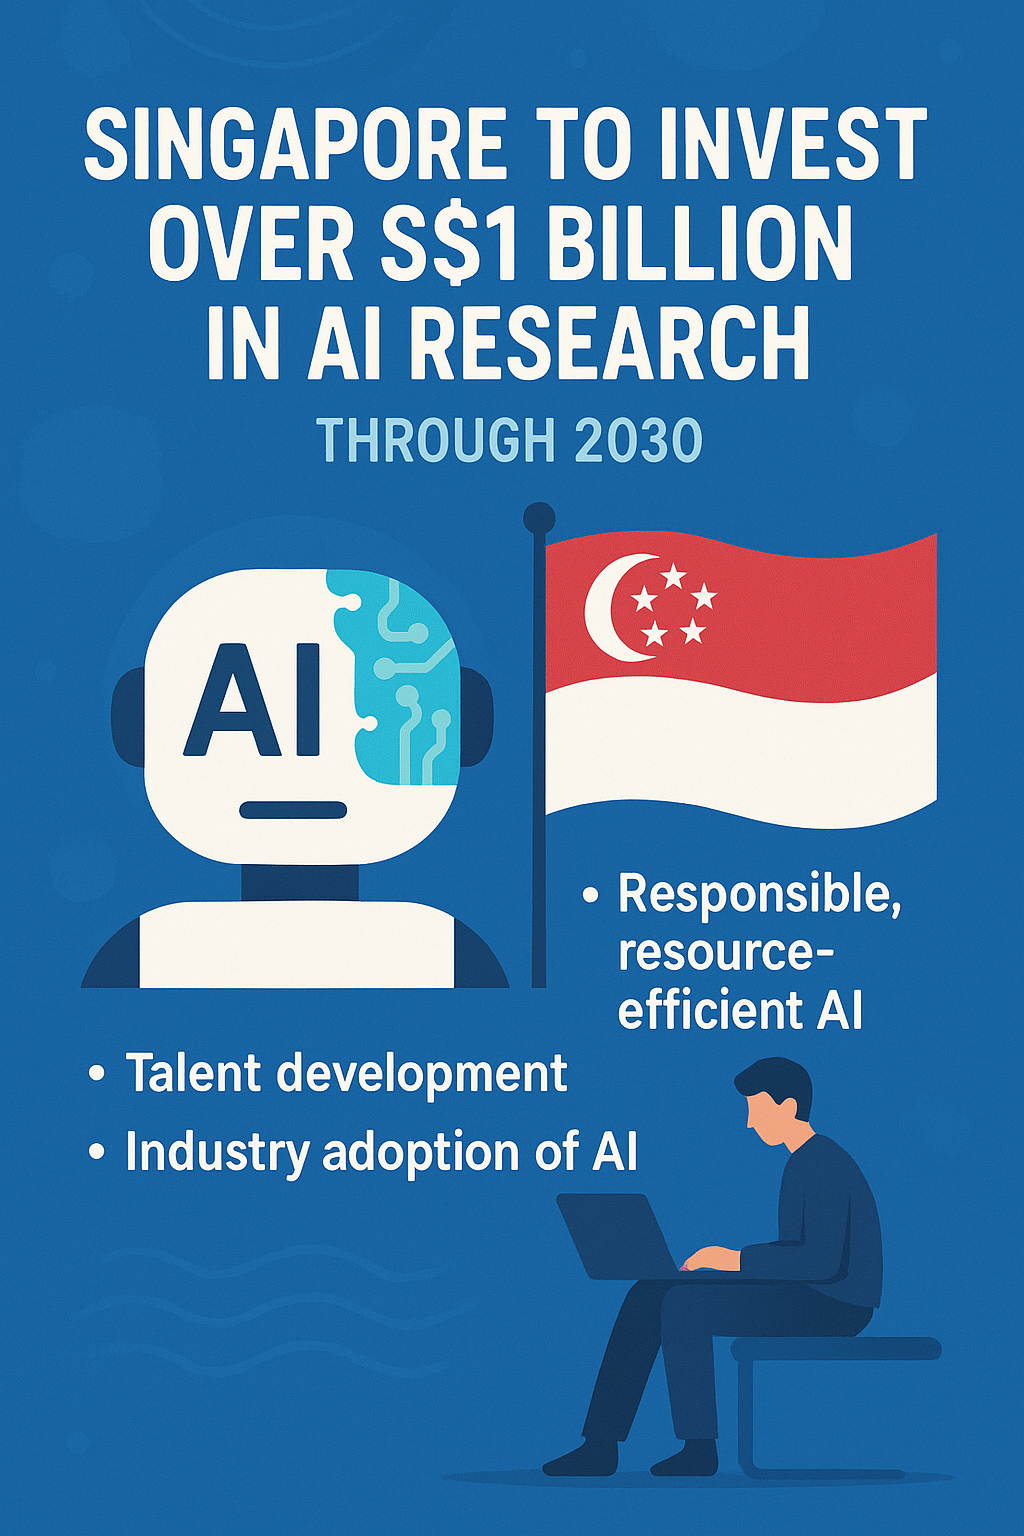

In [383]:
img = Image.open("/Users/Rakshit.Lodha/Desktop/ai-times/singapore")

display(img)